In [ ]:
!nvidia-smi

Mon Mar 17 17:47:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P0             28W /   70W |    1180MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q \
ultralytics \
supervision \
roboflow

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr" -O market-square.mp4 && rm -rf /tmp/cookies.txt


/content
--2025-03-17 17:48:04--  https://docs.google.com/uc?export=download&confirm=&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr
Resolving docs.google.com (docs.google.com)... 142.250.101.139, 142.250.101.100, 142.250.101.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr&export=download [following]
--2025-03-17 17:48:04--  https://drive.usercontent.google.com/download?id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21302928 (20M) [video/mp4]
Saving to: ‘market-square.mp4’

market-square.mp4   100%[===================>]  20.32M  83.9M

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv
from supervision.annotators.core import BoundingBoxAnnotator

In [ ]:
VIDEO_PATH = f"{HOME}/market-square.mp4"

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

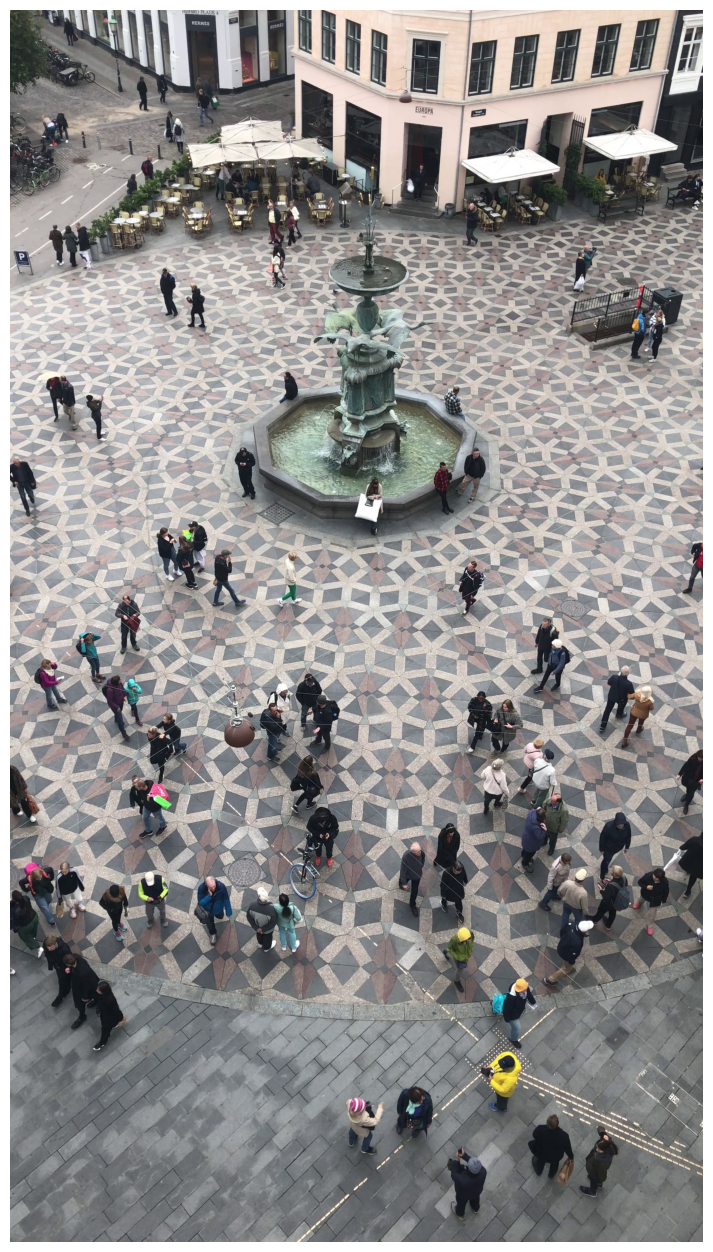

In [ ]:
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame,(16,16))

In [ ]:
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 311MB/s]


64


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


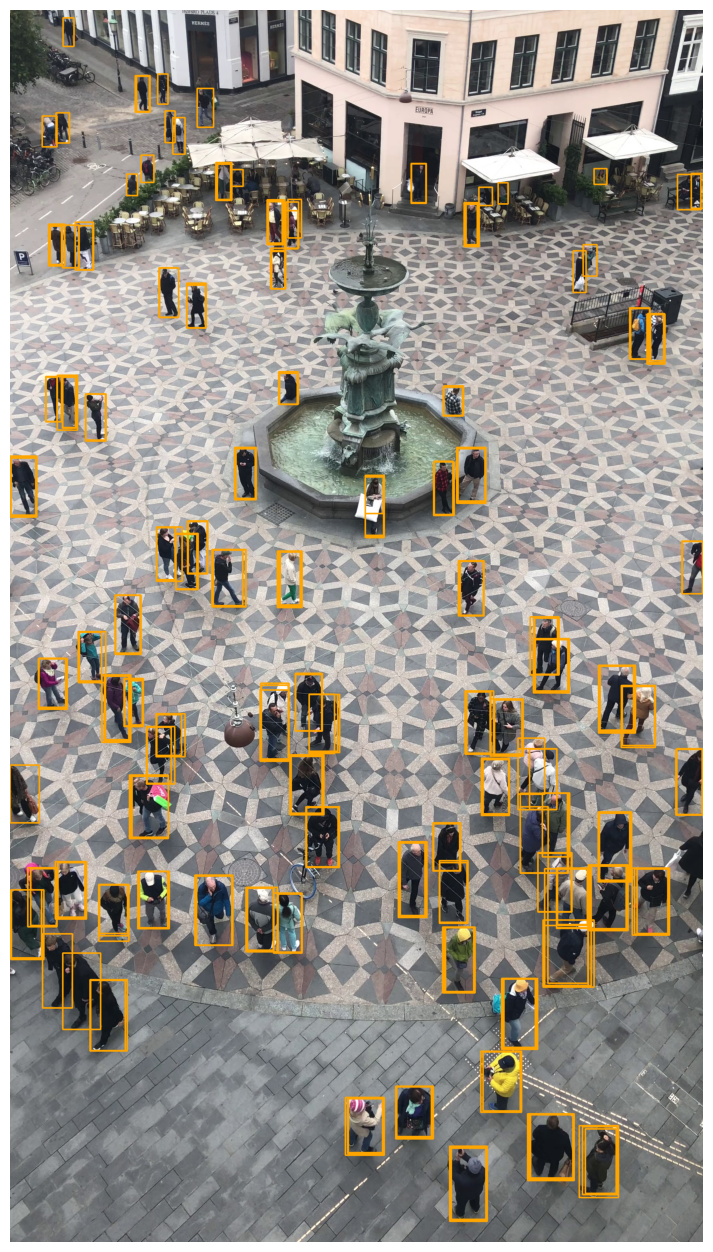

In [ ]:
results = model(frame, imgsz=2304, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]

print(len(detections))

labels = [
    f"{results.names[class_id]}: {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

#existen variaciones en los nombres de algunos contenedores

#box_annotators =sv.BoxAnnotator(
#thickness=4, text_thickness=2, text_scale=1,color=sv.Color.from_hex("#FFA500"))
#frame = box_annotators.annotate(scene=frame, detections=detections, labels=labels)

#box_corner_annotator = BoxCornerAnnotator
bounding_box_annotator = BoundingBoxAnnotator(
    color =sv.Color.from_hex("#FFA500"),
    thickness = 4,
    #corner_length = 15
)
frame = bounding_box_annotator.annotate(
    scene = frame,
    detections= detections
)

heat_map_annotator = sv.HeatMapAnnotator(
    position =  Position.BOTTOM_CENTER
    opacity = 0.2
    radius = 40
    kernel_size = 25
    top_hue = 0
    low_hue = 180
)
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)


frame = heat_map_annotator.annotate(
    scene = frame
)


sv.plot_image(frame,(16,16))

In [ ]:
#dibujar poligonos
import numpy as np


polygons = np.array([
    [0, 0],
    [1080 - 5, 0],
    [1080 - 5, 1300 - 5],
    [0, 1300 - 5]
])

colors = sv.ColorPalette.DEFAULT



#analiza el video frame por frame
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
image = frame
height, width, channels = image.shape

#problemas aqui .....
#trackter = sv.ByteTrack()
zones = sv.PolygonZone(
    polygon=polygons,
    #frame_resolution_wh=(width, width)
    )

zone_annotators = sv.PolygonZoneAnnotator(
    zone=zones, color=sv.Color.RED,
    thickness=5,
    text_thickness=10,
    text_scale=2)

box_annotators =sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)


results = model(frame, imgsz=1248)[0]
detections = sv.Detections.from_ultralytics(results)

mask = zones.trigger(detections=detections)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.5) & mask]

label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]



frame = box_annotators.annotate(scene=frame, detections=detections,labels=labels)
frame = zone_annotators.annotate(scene=frame)

sv.plot_image(frame, (16, 16))


TypeError: PolygonZone.__init__() got an unexpected keyword argument 'frame_resolution_wh'